In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random

In [2]:
# load the dataset
data_file = open('images_zero_one.txt', 'rb')
train_data, train_labels, test_data, test_labels = pickle.load(data_file, encoding='latin1')
data_file.close()

train_data = np.reshape(train_data, [-1, 28, 28])
test_data = np.reshape(test_data, [-1, 28, 28])
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)

# normalize the data, note that the testing data has to be manipulated in the same way as the training data
train_data = (train_data - np.mean(train_data)) / np.std(train_data)
test_data = (test_data - np.mean(train_data)) / np.std(train_data)

In [3]:
test_labels.shape

(1623,)

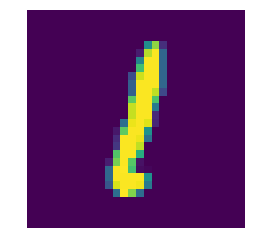

In [4]:
# Visualize the image
plt.figure(1)
img = train_data[1, :, :].reshape(28,28)
plt.imshow(img)
plt.axis('off')
plt.show()

In [5]:
hm_train, dim1, dim2 = train_data.shape
hm_test = len(test_labels)
hm_classes = 2
batch_size = 2
max_epoch = 1
eval_interval = 20
learning_rate = 0.0001
eps = 1e-8
beta1 = 0.9
beta2 = 0.999
test_acc = np.zeros((0, 1))
train_acc = np.zeros((0, 1))
train_loss = np.zeros((0, 1))

In [6]:
def init_weight(shape):
    w = np.ones(shape) / 100
    #w = np.abs(np.random.randn(shape[0], shape[1])) / 100
    return w


def init_bias(shape):
    b = np.ones(shape) * 0.001
    return b


def sigmoid_act(x):
    return 1 / (1 + np.exp(-x))
    
    
def sigmoid_grad(x):
    return sigmoid_act(x) * (1 - sigmoid_act(x))


def Relu_act(x):
    return (1 + np.sign(x)) / 2 * x


def Relu_grad(x):
    return (1 + np.sign(x)) / 2

In [7]:
def conv2d_np(images, filt2d):
    hm_im, d1, d2 = images.shape
    
    # default stride 1 and square filter with size 5
    stride = 1
    filter_size = 5
    conv_im = np.zeros([hm_im, int((d1-filter_size)/stride + 1), int((d2-filter_size)/stride + 1)])
    
    # convolve with the input images
    for im in np.arange(int(hm_im)):
        for i in np.arange(int((d1-filter_size+1)/stride)):
            for j in np.arange(int((d2-filter_size+1)/stride)):
                recep_area = images[im, i:i+filter_size, j:j+filter_size]
                conv_im[im, i, j] = np.sum(recep_area * filt2d)
                
    return conv_im

In [8]:
def avg_pool(images):
    hm_im, d1, d2 = images.shape
    # by default, the stride is 2, and the kernel is 2x2
    stride = 2
    kernel_size = 2
    pooled_im = np.zeros([hm_im, int((d1-kernel_size)/stride + 1), int((d2-kernel_size)/stride + 1)])
    for im in np.arange(int(hm_im)):
        for i in np.arange(int((d1-kernel_size)/stride + 1)):
            for j in np.arange(int((d2-kernel_size)/stride + 1)):
                recep_area = images[im, i * stride:i * stride + kernel_size, j * stride:j * stride + kernel_size]
                pooled_im[im, i, j] = np.mean(recep_area)
                
    return pooled_im

In [9]:
test_image = train_data[0:2, :, :]
test_label = train_labels[0:2][:, None]

W = {'w1': init_weight([5, 5]), 'b1': init_bias([24, 24]), \
    'w2': init_weight([5, 5]), 'b2': init_bias([24, 24]), \
    'w_fc': init_weight([144 * 2, 1]), 'b_fc': init_bias([1, 1])}

h_conv1 = Relu_act(conv2d_np(test_image, W['w1']) + W['b1'])
h_pool1 = avg_pool(h_conv1)

h_conv2 = Relu_act(conv2d_np(test_image, W['w2']) + W['b2'])
h_pool2 = avg_pool(h_conv2)

# feed into the fully connected layer
fc = np.hstack((h_pool1.reshape(-1, 144), h_pool2.reshape(-1, 144)))
y_out = np.dot(fc, W['w_fc']) + W['b_fc']
y_pred = sigmoid_act(y_out)

In [10]:
def compute_accuracy(data, labels, W):
    h_conv1 = Relu_act(conv2d_np(data, W['w1']) + W['b1'])
    h_pool1 = avg_pool(h_conv1)
    
    h_conv2 = Relu_act(conv2d_np(data, W['w2']) + W['b2'])
    h_pool2 = avg_pool(h_conv2)
    
    # feed into the fully connected layer
    fc = np.hstack((h_pool1.reshape(-1, 144), h_pool2.reshape(-1, 144)))
    y_out = np.dot(fc, W['w_fc']) + W['b_fc']
    
    pred_labels = (y_out > 0) * 1.
    #print(pred_labels.shape)
    #print(labels.shape)
    acc = np.sum(np.equal(pred_labels, labels) * 1.0) / len(labels)
    #print(np.equal(pred_labels, labels).shape)
    
    return acc

In [11]:
def compute_ce_sigmoid_loss(y_hat, y):
    return np.sum(y * -np.log(y_hat) + (1-y) * -np.log(1-y_hat))

In [12]:
# compute the gadients
Grad_W = {'w1': np.zeros([5, 5]), 'b1': np.zeros([24, 24]), \
    'w2': np.zeros([5, 5]), 'b2': np.zeros([24, 24]), \
    'w_fc': np.zeros([144 * 2, 1]), 'b_fc': np.zeros([1, 1])}

m_t = {'w1': np.zeros([5, 5]), 'b1': np.zeros([24, 24]), \
    'w2': np.zeros([5, 5]), 'b2': np.zeros([24, 24]), \
    'w_fc': np.zeros([144 * 2, 1]), 'b_fc': np.zeros([1, 1])}

cross_entropy_sigmoid = compute_ce_sigmoid_loss(y_pred, test_label)

In [13]:
def compute_gradients(W, x, h_conv1, h_conv2, fc, y, y_hat):
    # initialize the gradients to return
    Grad_W = {'w1': np.zeros([5, 5]), 'b1': np.zeros([24, 24]), \
    'w2': np.zeros([5, 5]), 'b2': np.zeros([24, 24]), \
    'w_fc': np.zeros([144 * 2, 1]), 'b_fc': np.zeros([1, 1])}
    
    Grad_W['w_fc'] = np.dot(np.transpose(fc), 2*y*y_hat - y - y_hat)
    Grad_W['b_fc'] = np.sum(2*y*y_hat - y - y_hat)
    Grad_fc = np.dot(2*y*y_hat - y - y_hat, np.transpose(W['w_fc']))
    
    act1 = np.zeros([24, 24])
    act2 = np.zeros([24, 24])
    for im in np.arange(len(y)):
        one_im = Grad_fc[im, :]
        pool1 = one_im[0:144].reshape(12, 12)
        pool2 = one_im[144:].reshape(12, 12)
        for i in np.arange(12):
            for j in np.arange(12):
                act1[i*2:i*2+2, j*2:j*2+2] = np.ones([2, 2]) * pool1[i, j] / 4
                act2[i*2:i*2+2, j*2:j*2+2] = np.ones([2, 2]) * pool2[i, j] / 4
                
        Grad_C1 = (h_conv1[im, :, :].reshape(24, 24) > 0) * act1
        Grad_C2 = (h_conv2[im, :, :].reshape(24, 24) > 0) * act2
        
        Grad_W['b1'] += Grad_C1
        Grad_W['b2'] += Grad_C2
        
        f1 = np.zeros([5, 5])
        f2 = np.zeros([5, 5])
        for r in np.arange(5):
            for c in np.arange(5):
                f1[r, c] = np.sum(x[im, r:r+24, c:c+24].reshape(24, 24) * Grad_C1)
                f2[r, c] = np.sum(x[im, r:r+24, c:c+24].reshape(24, 24) * Grad_C2)
                
        Grad_W['w1'] += f1
        Grad_W['w2'] += f2
        
    return Grad_W

In [14]:
Grad_W = compute_gradients(W, test_image, h_conv1, h_conv2, fc, test_label, y_pred)

In [15]:
print(Grad_W['w1'])

[[-0.20380894 -0.27027063 -0.2770126  -0.27396227 -0.2552794 ]
 [-0.24177034 -0.29419433 -0.29442414 -0.29264946 -0.26741981]
 [-0.26012179 -0.29442414 -0.29442414 -0.29442414 -0.25897422]
 [-0.26416191 -0.29315378 -0.29442414 -0.293476   -0.23489117]
 [-0.25489307 -0.27934354 -0.28198175 -0.27645617 -0.19596766]]


In [16]:
def train_opts(W, Grad_W, Cum_Grad_W, learning_rate):
    
    m_t['w1'] = m_t['w1'] * beta1 + (1 - beta1) * Grad_W['w1']
    W['w1'] -= learning_rate * m_t['w1'] / np.sqrt(Cum_Grad_W['w1'] + eps)
    m_t['b1'] = m_t['b1'] * beta1 + (1 - beta1) * Grad_W['b1']
    W['b1'] -= learning_rate * m_t['b1'] / np.sqrt(Cum_Grad_W['b1'] + eps)
    m_t['w2'] = m_t['w2'] * beta1 + (1 - beta1) * Grad_W['w2']
    W['w2'] -= learning_rate * m_t['w2'] / np.sqrt(Cum_Grad_W['w2'] + eps)
    m_t['b2'] = m_t['b2'] * beta1 + (1 - beta1) * Grad_W['b2']
    W['b2'] -= learning_rate * m_t['b2'] / np.sqrt(Cum_Grad_W['b2'] + eps)
    m_t['w_fc'] = m_t['w_fc'] * beta1 + (1 - beta1) * Grad_W['w_fc']
    W['w_fc'] -= learning_rate * m_t['w_fc'] / np.sqrt(Cum_Grad_W['w_fc'] + eps)
    m_t['b_fc'] = m_t['b_fc'] * beta1 + (1 - beta1) * Grad_W['b_fc']
    W['b_fc'] -= learning_rate * m_t['b_fc'] / np.sqrt(Cum_Grad_W['b_fc'] + eps)
    
    return W

def cumulate_grads(Grad_W, Cum_Grad_W):
    #beta2 * v_{t-1} + (1 - beta2) * g * g
    Cum_Grad_W['w1'] = Cum_Grad_W['w1'] * beta2 + (1 - beta2) * np.square(Grad_W['w1'])
    Cum_Grad_W['b1'] = Cum_Grad_W['b1'] * beta2 + (1 - beta2) * np.square(Grad_W['b1'])
    Cum_Grad_W['w2'] = Cum_Grad_W['w2'] * beta2 + (1 - beta2) * np.square(Grad_W['w2'])
    Cum_Grad_W['b2'] = Cum_Grad_W['b2'] * beta2 + (1 - beta2) * np.square(Grad_W['b2'])
    Cum_Grad_W['w_fc'] = Cum_Grad_W['w_fc'] * beta2 + (1 - beta2) * np.square(Grad_W['w_fc'])
    Cum_Grad_W['b_fc'] = Cum_Grad_W['b_fc'] * beta2 + (1 - beta2) * np.square(Grad_W['b_fc'])
    
    return Cum_Grad_W

In [17]:
max_intr = 800

# cumulative gradients for adamgrads
Cum_Grad_W = {'w1': np.zeros([5, 5]), 'b1': np.zeros([24, 24]), \
    'w2': np.zeros([5, 5]), 'b2': np.zeros([24, 24]), \
    'w_fc': np.zeros([144 * 2, 1]), 'b_fc': np.zeros([1, 1])}

#print(W['w1'])

for i in np.arange(max_intr):
    
    batch_x = train_data[i*batch_size:(i+1)*batch_size, :, :]
    batch_y = train_labels[i*batch_size:(i+1)*batch_size][:, None]
    #batch_x = train_data[0:2, :, :]
    #batch_y = train_labels[0:2][:, None]
    
    # Forward profess
    h_conv1 = Relu_act(conv2d_np(batch_x, W['w1']) + W['b1'])
    h_pool1 = avg_pool(h_conv1)

    h_conv2 = Relu_act(conv2d_np(batch_x, W['w2']) + W['b2'])
    h_pool2 = avg_pool(h_conv2)

    # feed into the fully connected layer
    fc = np.hstack((h_pool1.reshape(-1, 144), h_pool2.reshape(-1, 144)))
    y_out = np.dot(fc, W['w_fc']) + W['b_fc']
    y_pred = sigmoid_act(y_out)
    
    if i % eval_interval == 0:
        ce = compute_ce_sigmoid_loss(y_pred, batch_y)
        train_loss = np.vstack((train_loss, ce))
        
        tr = compute_accuracy(batch_x, batch_y, W)
        #print(test_labels.shape)
        #te = compute_accuracy(test_data, test_labels[:, None], W)
        
        train_acc = np.vstack((train_acc, tr))
        #test_acc = np.vstack((test_acc, te))
        #print("Iteration: %d, training accuracy: %g, testing accuracy: %g, loss: %g" %
        #                    (i, tr, te, np.mean(train_loss)))
        print(i, np.mean(train_loss), np.mean(train_acc))
        
    # compute the gradients and learning rate
    Grad_W = compute_gradients(W, batch_x, h_conv1, h_conv2, fc, batch_y, y_pred)
    Cum_Grad_W = cumulate_grads(Grad_W, Cum_Grad_W)
    #print(Cum_Grad_W['w1'].shape)
    #print(Cum_Grad_W['b1'].shape)
    l_r = learning_rate * np.sqrt(1 - np.power(beta2, i + 1)) / (1 - np.power(beta1, i + 1))
    W = train_opts(W, Grad_W, Cum_Grad_W, l_r)
    

0 1.24421339233 1.0
20 1.22225605867 1.0
40 1.47047368276 0.833333333333
60 1.64499782177 0.75
80 2.00220128324 0.6
100 1.94961671498 0.583333333333
120 2.52918196495 0.5
140 2.25731131472 0.5625
160 2.28643029694 0.555555555556
180 2.41991771467 0.55
200 2.23290860965 0.590909090909
220 2.45597894864 0.583333333333
240 2.66591179105 0.576923076923
260 2.48217714949 0.607142857143
280 2.32923288346 0.633333333333
300 2.20219503329 0.65625
320 2.7805439529 0.647058823529
340 2.82765612883 0.638888888889
360 3.36136187894 0.631578947368
380 3.1996489228 0.65
400 3.04732054567 0.666666666667
420 3.48814265009 0.659090909091
440 4.16096003509 0.630434782609
460 4.54192432424 0.625
480 5.03090360626 0.62
500 4.83748473882 0.634615384615
520 4.65843959271 0.648148148148
540 5.12953504787 0.642857142857
560 4.9526747789 0.655172413793
580 5.75253913074 0.65
600 6.54516675854 0.645161290323
620 6.76130789339 0.640625
640 8.33832540504 0.621212121212
660 9.10585168265 0.617647058824
680 8.84568

/Users/keyi/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


740 inf 0.631578947368
760 inf 0.641025641026
780 inf 0.65


In [ ]:
print(W['w1'])

In [ ]:
print(Grad_W['w1'])

In [20]:
print(compute_accuracy(test_data, test_labels[:, None], W))

0.55


In [ ]:
print(Grad_W['w_fc'])